# Charting PYLON Baselined Analysis Results

When you perform analysis with PYLON you receive aggregated results from the API. 

We carry out much of work with PYLON in iPython as by its nature the results is a documented workflow that can be easily shared.

In this notebook we'll take a look at how you can use common Python libraries to chart analysis results when you are analyzing against a **baseline audience**.

## Assumed knowledge

We won't explain all the basics of charting in this notebook. To get started with charting analysis results see [Charting PYLON Analysis Results](Charting PYLON Analysis Results.ipynb).

## Environment

To create this notebook we used:

* Python 2.7.6
* iPython 4.0.0
* pandas
* [DataSift client library](http://dev.datasift.com/tools/client-libraries)

The best way to install the above requirements is using [Anaconda](https://www.continuum.io/downloads). Anaconda provides a tested installation bundle including most popular Python packages.

## Baselining your analysis

It can be very powerful to show your results in comparison to another audience, we call this practice baselining.

When you carry out such analysis you'll record interactions for your audience you are analyzing into one index, then typically record data for your baseline audience into another index using a different filter. You may want to compare your audience to the general Facebook audience, to a different geography or demographic. This depends on your use case.

In this notebook we're assuming you submit the same analysis query to two different indexes and you want to plot both results for comparison.

### Plotting time series for comparison

We'll start by looking at time series.

In this example we:
* Parse both of our mocked API results into dictionaries.
* (Note we take only the **interactions** values from each to make comparison easier)
* Convert both results to dataframe and join these for plotting
* Plot the chart specifying 'silver' as the colour for the baseline result

In [3]:
import json

ts_audience_result = '''{
    "interactions": 3188400,
    "unique_authors": 2234300,
    "analysis": {
        "analysis_type": "timeSeries",
        "parameters": {
            "interval": "day"
        },
        "results": [
            {
                "key": 1448496000,
                "interactions": 312200,
                "unique_authors": 259900
            },
            {
                "key": 1448582400,
                "interactions": 539700,
                "unique_authors": 414100
            },
            {
                "key": 1448668800,
                "interactions": 578600,
                "unique_authors": 475600
            },
            {
                "key": 1448755200,
                "interactions": 561000,
                "unique_authors": 439600
            },
            {
                "key": 1448841600,
                "interactions": 588600,
                "unique_authors": 495500
            },
            {
                "key": 1448928000,
                "interactions": 608100,
                "unique_authors": 496800
            }
        ],
        "redacted": false
    }
}'''

ts_baseline_result = '''{
    "interactions": 3240400,
    "unique_authors": 1824300,
    "analysis": {
        "analysis_type": "timeSeries",
        "parameters": {
            "interval": "day"
        },
        "results": [
            {
                "key": 1448496000,
                "interactions": 311400,
                "unique_authors": 267900
            },
            {
                "key": 1448582400,
                "interactions": 519300,
                "unique_authors": 402900
            },
            {
                "key": 1448668800,
                "interactions": 526600,
                "unique_authors": 473200
            },
            {
                "key": 1448755200,
                "interactions": 579200,
                "unique_authors": 474300
            },
            {
                "key": 1448841600,
                "interactions": 533600,
                "unique_authors": 440500
            },
            {
                "key": 1448928000,
                "interactions": 548100,
                "unique_authors": 406800
            }
        ],
        "redacted": false
    }
}'''

ts_audience = json.loads(ts_audience_result)
ts_baseline = json.loads(ts_baseline_result)

Populating the interactive namespace from numpy and matplotlib


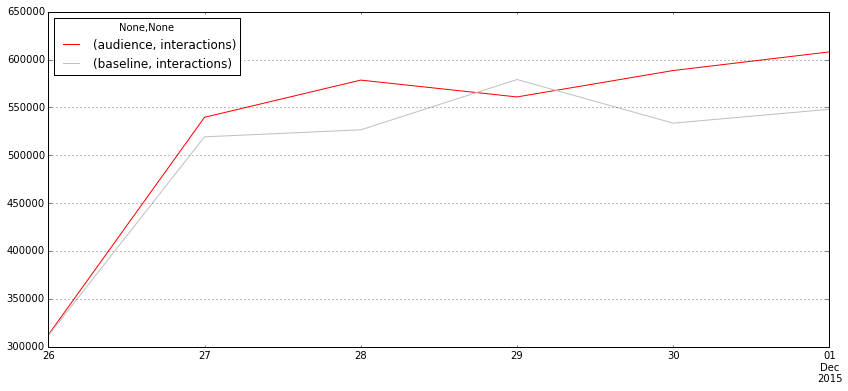

In [5]:
# This causes charts to be drawn inline
%pylab inline

# Import pandas for data manipulation
import pandas as pd

# Check result is not redacted
if not ts_audience['analysis']['redacted'] and not ts_baseline['analysis']['redacted']:

    # Extract results to dataframes & merge into one for plotting
    df_audience = pd.DataFrame.from_records(ts_audience['analysis']['results'],index='key',exclude=['unique_authors'])
    df_baseline = pd.DataFrame.from_records(ts_baseline['analysis']['results'],index='key',exclude=['unique_authors'])
    df_plot = pd.concat([df_audience,df_baseline], axis=1, keys=['audience', 'baseline'])
 
    # Map the index labels to readable dates
    df_plot.index=df_plot.index.map(datetime.datetime.fromtimestamp)
    
    # Sort the data and plot a chart
    df_plot.sort().plot(figsize=(14,6), color=['red','silver'])

### Plotting frequency distributions for comparison

You can apply the same idea to frequency distributions of course.

In this example we:
* Parse both of our mocked API results into dictionaries.
* Note we take only the **unique_authors** values from each to make comparison easier
* Merge both results into one dataframe. 
* Plot each result in turn on the same axes, layering the visualization. Again 'silver' is used as the colour for the baseline.

In [6]:
fd_audience_result = '''{
    "interactions": 3188400,
    "unique_authors": 2234300,
    "analysis": {
        "analysis_type": "freqDist",
        "parameters": {
            "target": "fb.author.country",
            "threshold": 6
        },
        "results": [
            {
                "key": "United States",
                "interactions": 1121300,
                "unique_authors": 781400
            },
            {
                "key": "Brazil",
                "interactions": 283100,
                "unique_authors": 204800
            },
            {
                "key": "Turkey",
                "interactions": 181000,
                "unique_authors": 136700
            },
            {
                "key": "United Kingdom",
                "interactions": 172800,
                "unique_authors": 128400
            },
            {
                "key": "Mexico",
                "interactions": 151200,
                "unique_authors": 95000
            },
            {
                "key": "Germany",
                "interactions": 122000,
                "unique_authors": 84800
            }
        ],
        "redacted": false
    }
}'''

fd_baseline_result = '''{
    "interactions": 3188400,
    "unique_authors": 2234300,
    "analysis": {
        "analysis_type": "freqDist",
        "parameters": {
            "target": "fb.author.country",
            "threshold": 6
        },
        "results": [
            {
                "key": "United States",
                "interactions": 1781400,
                "unique_authors": 981400
            },
            {
                "key": "Brazil",
                "interactions": 274200,
                "unique_authors": 120200
            },
            {
                "key": "Turkey",
                "interactions": 171000,
                "unique_authors": 126700
            },
            {
                "key": "United Kingdom",
                "interactions": 222400,
                "unique_authors": 198400
            },
            {
                "key": "Mexico",
                "interactions": 161200,
                "unique_authors": 96000
            },
            {
                "key": "Germany",
                "interactions": 129000,
                "unique_authors": 84900
            }
        ],
        "redacted": false
    }
}'''

fd_audience = json.loads(fd_audience_result)
fd_baseline = json.loads(fd_baseline_result)

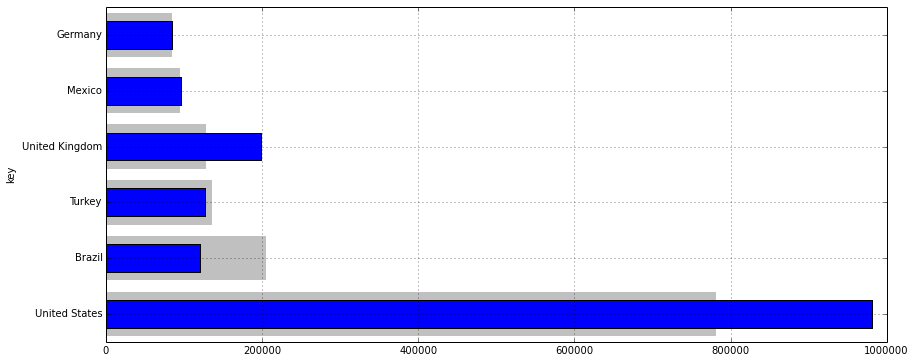

In [7]:
# Check result is not redacted
if not fd_audience['analysis']['redacted'] and not fd_baseline['analysis']['redacted']:

    # Extract result data to dataframe
    df_audience = pd.DataFrame.from_records(fd_audience['analysis']['results'],index='key',exclude=['interactions'])
    df_baseline = pd.DataFrame.from_records(fd_baseline['analysis']['results'],index='key',exclude=['interactions'])
    df_plot = pd.concat([df_audience, df_baseline], axis=1, keys=['audience', 'baseline'])
    
    # Sort the data and plot a chart
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
    df_plot[('audience','unique_authors')].plot(kind='barh',ax=axes,color='silver',width=0.8,linewidth=0)
    df_plot[('baseline','unique_authors')].plot(kind='barh',ax=axes)

### Baselining an age-gender pyramid

If you've previously charted a demographic breadown as a pyramid, you can also consider a baselined comparison for this.

In this example we:
* Parse both of our mocked API results into dictionaries.
* Create a dataframe for our audience and our baseline audience.
* For both sexes plot firstly the baseline chart and then on top plot the audience chart.

In [12]:
nested_audience_result = '''{
    "unique_authors": 556400, 
    "analysis": {
        "analysis_type": "freqDist", 
        "redacted": false, 
        "results": [
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 124500, 
                            "key": "18-24", 
                            "interactions": 151900
                        }, 
                        {
                            "unique_authors": 124200, 
                            "key": "25-34", 
                            "interactions": 146200
                        }, 
                        {
                            "unique_authors": 76400, 
                            "key": "35-44", 
                            "interactions": 96000
                        }, 
                        {
                            "unique_authors": 43800, 
                            "key": "45-54", 
                            "interactions": 57400
                        }, 
                        {
                            "unique_authors": 19500, 
                            "key": "55-64", 
                            "interactions": 26400
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 404800, 
                "key": "male", 
                "interactions": 492000
            }, 
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 34300, 
                            "key": "25-34", 
                            "interactions": 43200
                        }, 
                        {
                            "unique_authors": 31200, 
                            "key": "35-44", 
                            "interactions": 35600
                        }, 
                        {
                            "unique_authors": 31200, 
                            "key": "18-24", 
                            "interactions": 34800
                        }, 
                        {
                            "unique_authors": 21400, 
                            "key": "45-54", 
                            "interactions": 26400
                        }, 
                        {
                            "unique_authors": 12600, 
                            "key": "55-64", 
                            "interactions": 15500
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 141400, 
                "key": "female", 
                "interactions": 164500
            }
        ], 
        "parameters": {
            "threshold": 2, 
            "target": "fb.author.gender"
        }
    }, 
    "interactions": 671300
}'''

nested_baseline_result = '''{
    "unique_authors": 556400, 
    "analysis": {
        "analysis_type": "freqDist", 
        "redacted": false, 
        "results": [
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 122500, 
                            "key": "18-24", 
                            "interactions": 151000
                        }, 
                        {
                            "unique_authors": 114200, 
                            "key": "25-34", 
                            "interactions": 136200
                        }, 
                        {
                            "unique_authors": 82400, 
                            "key": "35-44", 
                            "interactions": 104000
                        }, 
                        {
                            "unique_authors": 63800, 
                            "key": "45-54", 
                            "interactions": 77400
                        }, 
                        {
                            "unique_authors": 19300, 
                            "key": "55-64", 
                            "interactions": 26200
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 404800, 
                "key": "male", 
                "interactions": 492000
            }, 
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 49300, 
                            "key": "25-34", 
                            "interactions": 56200
                        }, 
                        {
                            "unique_authors": 39200, 
                            "key": "35-44", 
                            "interactions": 40600
                        }, 
                        {
                            "unique_authors": 33200, 
                            "key": "18-24", 
                            "interactions": 35800
                        }, 
                        {
                            "unique_authors": 19400, 
                            "key": "45-54", 
                            "interactions": 24400
                        }, 
                        {
                            "unique_authors": 11600, 
                            "key": "55-64", 
                            "interactions": 14500
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 141400, 
                "key": "female", 
                "interactions": 164500
            }
        ], 
        "parameters": {
            "threshold": 2, 
            "target": "fb.author.gender"
        }
    }, 
    "interactions": 671300
}'''

nested_audience = json.loads(nested_audience_result)
nested_baseline = json.loads(nested_baseline_result)

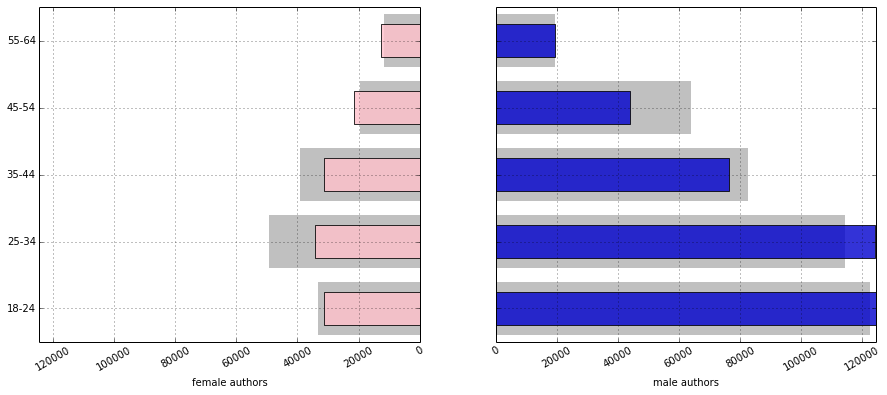

In [13]:
from matplotlib import gridspec

if not nested_audience['analysis']['redacted'] and not nested_baseline['analysis']['redacted']:
    
    # Prepare dataframe for audience
    df_audience_male = pd.DataFrame.from_records(
        nested_audience['analysis']['results'][0]['child']['results'],index='key')
    
    df_audience_female = pd.DataFrame.from_records(
        nested_audience['analysis']['results'][1]['child']['results'],index='key')
    
    df_audience = pd.concat([df_audience_male, df_audience_female], axis=1, keys=['male','female'])
    
    # Prepare dataframe for baseline
    df_baseline_male = pd.DataFrame.from_records(
        nested_baseline['analysis']['results'][0]['child']['results'],index='key')
    
    df_baseline_female = pd.DataFrame.from_records(
        nested_baseline['analysis']['results'][1]['child']['results'],index='key')
    
    df_baseline = pd.concat([df_baseline_male, df_baseline_female], axis=1, keys=['male','female'])
    
    # Create plot layout
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
    axes=map(plt.subplot,gs)
    
    # Find max X value across data sets
    max_xlim=max(df_audience[('male', 'unique_authors')].max(),
        df_audience[('female', 'unique_authors')].max(),
        df_baseline[('male', 'unique_authors')].max(),
        df_baseline[('male', 'unique_authors')].max())
    
    # Plot pyramid
    female_subplot=df_baseline[('female','unique_authors')].plot(kind='barh',ax=axes[0],color='silver',width=0.8,linewidth=0)
    df_audience[('female','unique_authors')].plot(kind='barh',ax=axes[0],color='pink',alpha=0.8) #royalblue
    female_subplot.set_xlim([max_xlim,0])
    
    male_subplot=df_baseline[('male','unique_authors')].plot(kind='barh',ax=axes[1],color='silver',width=0.8,linewidth=0)
    df_audience[('male','unique_authors')].plot(kind='barh',ax=axes[1],color='mediumblue',alpha=0.8)
    male_subplot.set_xlim([0,max_xlim])
    
    # Tidy axis labels
    axes[0].set_xlabel('female authors')
    axes[1].set_xlabel('male authors')
    axes[1].set_ylabel('')
    axes[1].set_yticklabels(['' for item in axes[1].get_yticklabels()]) 
    for i in (0,1):
        for j in axes[i].xaxis.get_major_ticks():
            j.label.set_rotation(30)

# What next?

Now you've learnt some further charting skills take a look at the other examples in this repository, such as:
* [Charting PYLON Nested Query Analysis Results](Charting PYLON Nested Query Analysis Results.ipynb)